## Dataset Class

### GNN Link Prediction Workflow

#### 1. Data Preparation
- [ ] Obtain dataset (e.g., Cora, CiteSeer)
- [ ] Preprocess data:
  - [ ] Normalize node features
  - [ ] Convert to undirected graph (if needed)
- [x] Split edges:
  - [x] Training set (80%)
  - [x] Validation set (10%)
  - [x] Test set (10%)
- [x] Generate negative samples:
  - [ ] Validation negatives (1:1 ratio)
  - [ ] Test negatives (1:1 ratio)

#### 2. Model Architecture
- [ ] Implement GNN encoder:
  - [ ] Choose layer type (GCN/GraphSAGE)
  - [ ] 2-layer architecture
  - [ ] ReLU activation
- [ ] Implement decoder:
  - [ ] Dot product scorer
  - [ ] Sigmoid activation

#### 3. Training Setup
- [ ] Initialize optimizer (Adam)
- [ ] Set learning rate (~0.01)
- [ ] Define loss function (BCE)
- [ ] Implement negative sampling:
  - [ ] Dynamic per-epoch sampling
  - [ ] 1:1 positive:negative ratio

#### 4. Evaluation Metrics
- [ ] AUC-ROC calculation
- [ ] Accuracy/F1-score
- [ ] Precision-Recall curve

#### 5. PyTorch Implementation
- [ ] Environment setup:
  ```bash
  pip install torch torch_geometric

to do 
-  fix matching nodes
- problem with node2vec?
- weighted loss
- check that dataset are shuffled correctly and (for every positive lncRNA create multiple engative links)
- check that you are not creating ngeative links where positive links exist
- paper that they have sent

In [85]:
import torch
import pandas as pd
from torch_geometric.data import Dataset, Data
import numpy as np
## Hetero data
class LinkPredictionDataset(Dataset):
    def __init__(self, net_path, label_path, node2vec_path=None, transform=None):
        super().__init__(transform=transform)
        
        # Load data
        self.net_df = pd.read_csv(net_path)
        self.label_df = pd.read_csv(label_path)
        
        # Filter for lncRNA-related edges
        self.net_df = self.net_df[
            (self.net_df['RegulatorType'] == 'lncRNA') | (self.net_df['TargetType'] == 'lncRNA')
        ].reset_index(drop=True)
        
        # Create node mappings
        all_nodes = set(self.net_df['Regulator']).union(set(self.net_df['Target']))
        self.node_to_idx = {node: idx for idx, node in enumerate(all_nodes)}
        self.idx_to_node = {idx: node for node, idx in self.node_to_idx.items()}
        
        # Store node types for negative sampling
        self.node_types = {}
        for _, row in self.net_df.iterrows():
            self.node_types[self.node_to_idx[row['Regulator']]] = row['RegulatorType']
            self.node_types[self.node_to_idx[row['Target']]] = row['TargetType']
        
        # Create edge index and edge types from network data
        regulators = [self.node_to_idx[reg] for reg in self.net_df['Regulator']]
        targets = [self.node_to_idx[target] for target in self.net_df['Target']]
        self.edge_index = torch.tensor([regulators, targets], dtype=torch.long)
        
        # Define relation types (e.g., lncRNA_mRNA, miRNA_lncRNA, etc.)
        relation_map = {}
        relation_counter = 0
        edge_types = []
        for _, row in self.net_df.iterrows():
            rel_type = f"{row['RegulatorType']}_{row['TargetType']}"
            if rel_type not in relation_map:
                relation_map[rel_type] = relation_counter
                relation_counter += 1
            edge_types.append(relation_map[rel_type])
        self.edge_type = torch.tensor(edge_types, dtype=torch.long)
        self.num_relations = len(relation_map)
        self.relation_map = relation_map  # Optional: for reference
        
        # Node features
        self.num_nodes = len(all_nodes)

        
        if node2vec_path is not None:
            node2vec_df = pd.read_csv(node2vec_path, index_col=0)
            node2vec_df = node2vec_df.apply(pd.to_numeric, errors='coerce')
            features = []
            for idx in range(self.num_nodes):
                node_name = self.idx_to_node[idx]
                if node_name in node2vec_df.index:
                    features.append(node2vec_df.loc[node_name].values)
                else:
                    features.append(np.zeros(node2vec_df.shape[1]))
            self.x = torch.tensor(np.stack(features), dtype=torch.float)
        else:
            self.x = torch.eye(self.num_nodes, dtype=torch.float)
        
        self.edge_labels = torch.ones(len(regulators), dtype=torch.float)
        
    def len(self):
        return 1
    
    def get(self, idx):
        data = Data(
            x=self.x,
            edge_index=self.edge_index,
            edge_type=self.edge_type,  # <-- crucial for R-GCN
            edge_attr=self.edge_labels,
            num_nodes=self.num_nodes
        )
        # Attach node_types for use in negative sampling
        data.node_types = self.node_types
        data.idx_to_node = self.idx_to_node
        data.node_to_idx = self.node_to_idx
        data.num_relations = self.num_relations
        data.relation_map = self.relation_map
        if self.transform:
            data = self.transform(data)
        return data

# Usage example:
dataset = LinkPredictionDataset(
    '/Users/marinamomina/Desktop/studium/master/1_Sem/ML4RG/LincGNN/LinkPrediction/data/Net_final.csv',
    '/Users/marinamomina/Desktop/studium/master/1_Sem/ML4RG/LincGNN/LinkPrediction/data/Label_final.csv',
    node2vec_path="/Users/marinamomina/Desktop/studium/master/1_Sem/ML4RG/LincGNN/NodePre/lncRNA_emb_features.csv"
)
data = dataset[0]
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.edge_index.size(1)}")
print(f"Edge type shape: {data.edge_type.shape}")
print(f"Relation types: {dataset.relation_map}")

Number of nodes: 2417
Number of edges: 4250
Edge type shape: torch.Size([4250])
Relation types: {'lncRNA_miRNA': 0, 'lncRNA_PCG': 1}


In [94]:
import torch
import pandas as pd
from torch_geometric.data import Dataset, Data
import numpy as np
## Heterodataset
class RGCNLinkPredictionDataset(Dataset):
    def __init__(self, net_path, label_path, node2vec_path=None, transform=None):
        super().__init__(transform=transform)
        
        # Load data
        self.net_df = pd.read_csv(net_path)
        self.label_df = pd.read_csv(label_path)
        
        # Filter for lncRNA-related edges
        self.net_df = self.net_df[
            (self.net_df['RegulatorType'] == 'lncRNA') | (self.net_df['TargetType'] == 'lncRNA')
        ].reset_index(drop=True)
        
        # Create node mappings
        all_nodes = list(set(self.net_df['Regulator']).union(set(self.net_df['Target'])))
        self.node_to_idx = {node: idx for idx, node in enumerate(all_nodes)}
        self.idx_to_node = {idx: node for node, idx in self.node_to_idx.items()}
        
        # Store node types for negative sampling
        self.node_types = {}
        for _, row in self.net_df.iterrows():
            self.node_types[self.node_to_idx[row['Regulator']]] = row['RegulatorType']
            self.node_types[self.node_to_idx[row['Target']]] = row['TargetType']
        
        # Create edge index
        regulators = [self.node_to_idx[reg] for reg in self.net_df['Regulator']]
        targets = [self.node_to_idx[target] for target in self.net_df['Target']]
        self.edge_index = torch.tensor([regulators, targets], dtype=torch.long)
        
        # Create relation types for R-GCN
        relation_map = {}
        relation_counter = 0
        edge_types = []
        
        for _, row in self.net_df.iterrows():
            rel_type = f"{row['RegulatorType']}_{row['TargetType']}"
            if rel_type not in relation_map:
                relation_map[rel_type] = relation_counter
                relation_counter += 1
            edge_types.append(relation_map[rel_type])
        
        self.edge_type = torch.tensor(edge_types, dtype=torch.long)
        self.num_relations = len(relation_map)
        self.relation_map = relation_map
        
        # Node features
        self.num_nodes = len(all_nodes)
        
        if node2vec_path is not None:
            node2vec_df = pd.read_csv(node2vec_path, index_col=0)
            node2vec_df = node2vec_df.apply(pd.to_numeric, errors='coerce')
            features = []
            for idx in range(self.num_nodes):
                node_name = self.idx_to_node[idx]
                if node_name in node2vec_df.index:
                    features.append(node2vec_df.loc[node_name].values)
                else:
                    features.append(np.zeros(node2vec_df.shape[1]))
            self.x = torch.tensor(np.stack(features), dtype=torch.float)
        else:
            self.x = torch.eye(self.num_nodes, dtype=torch.float)
        
    def len(self):
        return 1
    
    def get(self, idx):
        data = Data(
            x=self.x,
            edge_index=self.edge_index,
            edge_type=self.edge_type,  # Essential for R-GCN
            num_nodes=self.num_nodes
        )
        
        # Metadata for negative sampling
        data.node_types = self.node_types
        data.idx_to_node = self.idx_to_node
        data.node_to_idx = self.node_to_idx
        data.num_relations = self.num_relations
        data.relation_map = self.relation_map
        
        if self.transform:
            data = self.transform(data)
        return data
    
# Usage example:
dataset = RGCNLinkPredictionDataset(
    '/Users/marinamomina/Desktop/studium/master/1_Sem/ML4RG/LincGNN/LinkPrediction/data/Net_final.csv',
    '/Users/marinamomina/Desktop/studium/master/1_Sem/ML4RG/LincGNN/LinkPrediction/data/Label_final.csv',
    node2vec_path="/Users/marinamomina/Desktop/studium/master/1_Sem/ML4RG/LincGNN/NodePre/lncRNA_emb_features.csv"
)
data = dataset[0]

In [32]:
from collections import Counter
print(Counter(data.node_types.values()))

Counter({'PCG': 1400, 'lncRNA': 605, 'miRNA': 412})


In [95]:
import pandas as pd

# Get edge indices as numpy array
edge_array = data.edge_index.numpy()
edge_types = data.edge_type.numpy()

# Build DataFrame with node names and types
df = pd.DataFrame({
    "Source_idx": edge_array[0],
    "Source_name": [data.idx_to_node[idx] for idx in edge_array[0]],
    "Source_type": [data.node_types[idx] for idx in edge_array[0]],
    "Target_idx": edge_array[1],
    "Target_name": [data.idx_to_node[idx] for idx in edge_array[1]],
    "Target_type": [data.node_types[idx] for idx in edge_array[1]],
    "Edge_type": edge_types
})

print(df.head(10))  # Show first 10 edges
print(df.tail(10))  # Show last 10 edges

import pandas as pd

# Convert node features tensor to numpy array
features = data.x.numpy()
# Get node names for the index
node_names = [data.idx_to_node[idx] for idx in range(data.num_nodes)]

# Create DataFrame for node features
features_df = pd.DataFrame(features, index=node_names)
print(features_df.head(10))  # Show first 10 nodes and their features
print(features_df.tail(10))  # Show last 10 nodes and their features

   Source_idx Source_name Source_type  Target_idx  Target_name Target_type  \
0        1805       NEAT1      lncRNA        1070   miR-194-5p       miRNA   
1          26   LINC00460      lncRNA         664      miR-206       miRNA   
2         368      MALAT1      lncRNA        2147      miR-497       miRNA   
3        1216        MIAT      lncRNA         654      miR-29b       miRNA   
4         393  CDKN2B-AS1      lncRNA        1038  miR-181a-5p       miRNA   
5        1895        GAS5      lncRNA        1860        MIR21       miRNA   
6         368      MALAT1      lncRNA         692     miR-216b       miRNA   
7         415       CASC2      lncRNA         848      miR-214       miRNA   
8         302  PCED1B-AS1      lncRNA        1688      miR-155       miRNA   
9         382   LINC00662      lncRNA         127   miR-340-5p       miRNA   

   Edge_type  
0          0  
1          0  
2          0  
3          0  
4          0  
5          0  
6          0  
7          0  
8     

In [99]:
def sample_lncrna_negatives(edge_index, num_nodes, node_types, num_samples):
    # Only sample negatives where at least one node is lncRNA
    existing = set((u, v) for u, v in edge_index.t().tolist())
    negatives = []
    tries = 0
    max_tries = num_samples * 10
    lncrna_nodes = [idx for idx, t in node_types.items() if t == 'lncRNA']
    all_nodes = list(range(num_nodes))
    while len(negatives) < num_samples and tries < max_tries:
        src = np.random.choice(lncrna_nodes)
        dst = np.random.choice(all_nodes)
        if src == dst:
            tries += 1
            continue
        if (src, dst) not in existing and (dst, src) not in existing:
            negatives.append([src, dst])
        tries += 1
    return torch.tensor(negatives).t()  # shape [2, num_negatives]

In [101]:
#data = dataset[0]

# Split positive edges (e.g., 80/10/10)
num_edges = data.edge_index.size(1)
perm = torch.randperm(num_edges)
num_val = int(0.1 * num_edges)
num_test = int(0.1 * num_edges)
val_idx = perm[:num_val]
test_idx = perm[num_val:num_val+num_test]
train_idx = perm[num_val+num_test:]

train_pos = data.edge_index[:, train_idx]
val_pos = data.edge_index[:, val_idx]
test_pos = data.edge_index[:, test_idx]

# Sample negatives for each split
train_neg = sample_lncrna_negatives(data.edge_index, data.num_nodes, data.node_types, train_pos.size(1))
val_neg = sample_lncrna_negatives(data.edge_index, data.num_nodes, data.node_types, val_pos.size(1))
test_neg = sample_lncrna_negatives(data.edge_index, data.num_nodes, data.node_types, test_pos.size(1))

train_edge_type = data.edge_type[train_idx]
val_edge_type = data.edge_type[val_idx]
test_edge_type = data.edge_type[test_idx]

train_data = Data(
    x=data.x,
    edge_index=data.edge_index,
    edge_type=data.edge_type,  # full graph for message passing
    edge_label_index=torch.cat([train_pos, train_neg], dim=1),
    edge_label=torch.cat([torch.ones(train_pos.size(1)), torch.zeros(train_neg.size(1))]),
    train_edge_type=train_edge_type  # for reference if needed
)
val_data = Data(
    x=data.x,
    edge_index=data.edge_index,
    edge_type=data.edge_type,
    edge_label_index=torch.cat([val_pos, val_neg], dim=1),
    edge_label=torch.cat([torch.ones(val_pos.size(1)), torch.zeros(val_neg.size(1))]),
    val_edge_type=val_edge_type
)
test_data = Data(
    x=data.x,
    edge_index=data.edge_index,
    edge_type=data.edge_type,
    edge_label_index=torch.cat([test_pos, test_neg], dim=1),
    edge_label=torch.cat([torch.ones(test_pos.size(1)), torch.zeros(test_neg.size(1))]),
    test_edge_type=test_edge_type
)

#metadata
# For train_data:
train_data.num_nodes = data.num_nodes
train_data.node_types = data.node_types  # Needed for create_node_type_tensor()

# For val_data:
val_data.num_nodes = data.num_nodes
val_data.node_types = data.node_types

# For test_data:
test_data.num_nodes = data.num_nodes
test_data.node_types = data.node_types

In [102]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# class GCNLinkPredictor(nn.Module):
#     def __init__(self, in_channels, hidden_channels, num_relations):
#         super().__init__()
#         self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
#         self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations)
        
#     def encode(self, x, edge_index, edge_type):
#         x = self.conv1(x, edge_index, edge_type)
#         x = F.relu(x)
#         x = self.conv2(x, edge_index, edge_type)
#         return x

#     def decode(self, z, edge_label_index):
#         src, dst = edge_label_index
#         return (z[src] * z[dst]).sum(dim=1)

#     def forward(self, x, edge_index, edge_type, edge_label_index):
#         z = self.encode(x, edge_index, edge_type)
#         logits = self.decode(z, edge_label_index)
#         return logits
# class GCNLinkPredictor(nn.Module):
#     def __init__(self, in_channels, hidden_channels, num_relations, dropout=0.3):
#         super().__init__()
#         self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
#         self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations)
#         self.dropout = nn.Dropout(dropout)
        
#         # Optional: Batch normalization
#         self.bn1 = nn.BatchNorm1d(hidden_channels)
        
#     def encode(self, x, edge_index, edge_type):
#         x = self.conv1(x, edge_index, edge_type)
#         x = self.bn1(x)  # Batch normalization
#         x = F.relu(x)
#         x = self.dropout(x)  # Dropout after activation
        
#         x = self.conv2(x, edge_index, edge_type)
#         x = self.dropout(x)  # Dropout on final embeddings
#         return x

#     def decode(self, z, edge_label_index):
#         src, dst = edge_label_index
#         return (z[src] * z[dst]).sum(dim=1)

#     def forward(self, x, edge_index, edge_type, edge_label_index):
#         z = self.encode(x, edge_index, edge_type)
#         logits = self.decode(z, edge_label_index)
#         return logits

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

class GCNLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_relations, num_node_types, dropout=0.3):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations)
        self.dropout = nn.Dropout(dropout)
        
        # Node type embeddings
        self.node_type_emb = nn.Embedding(num_node_types, hidden_channels)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        
    def encode(self, x, edge_index, edge_type, node_type):
        x = self.conv1(x, edge_index, edge_type)
        
        # Add node type information
        type_emb = self.node_type_emb(node_type)
        x = x + type_emb
        
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index, edge_type)
        x = self.dropout(x)
        return x

    def decode(self, z, edge_label_index):
        src, dst = edge_label_index
        return (z[src] * z[dst]).sum(dim=1)

    def forward(self, x, edge_index, edge_type, edge_label_index, node_type):
        z = self.encode(x, edge_index, edge_type, node_type)
        logits = self.decode(z, edge_label_index)
        return logits
# 2. Prepare data splits (already done with RandomLinkSplit)
# train_data, val_data, test_data = transform(data)

# 3. Training setup

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GCNLinkPredictor(
#     in_channels=train_data.x.size(1),
#     hidden_channels=32,
#     num_relations=train_data.edge_type.max().item() + 1
# ).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# loss_fn = nn.BCEWithLogitsLoss()

# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(
#         train_data.x.to(device),
#         train_data.edge_index.to(device),
#         train_data.edge_type.to(device),           # <-- pass edge_type!
#         train_data.edge_label_index.to(device)
#     )
#     loss = loss_fn(out, train_data.edge_label.to(device))
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# @torch.no_grad()
# def test(data):
#     model.eval()
#     logits = model(
#         data.x.to(device),
#         data.edge_index.to(device),
#         data.edge_type.to(device),                 # <-- pass edge_type!
#         data.edge_label_index.to(device)
#     )
#     probs = torch.sigmoid(logits).cpu().numpy()
#     labels = data.edge_label.cpu().numpy()
#     auc_score = roc_auc_score(labels, probs)
#     preds = (probs > 0.5).astype(int)
#     acc = accuracy_score(labels, preds)
#     f1 = f1_score(labels, preds)
#     precision, recall, _ = precision_recall_curve(labels, probs)
#     pr_auc = auc(recall, precision)
#     cm = confusion_matrix(labels, preds)
#     return auc_score, acc, f1, pr_auc, cm
# # 4. Training loop
# # ...existing code for training loop...
# epochs = 100
# train_losses = []
# val_aucs = []

# for epoch in range(1, epochs+1):
#     loss = train()
#     train_losses.append(loss)
#     val_auc, val_acc, val_f1, val_pr_auc, val_cm = test(val_data)
#     val_aucs.append(val_auc)
#     if epoch % 10 == 0 or epoch == 1:
#         print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")

# # Plot Training Loss
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, epochs+1), train_losses, color='tab:blue', label='Training Loss', linewidth=2)
# plt.xlabel('Epoch', fontsize=12)
# plt.ylabel('Loss', fontsize=12)
# plt.title('Training Loss over Epochs', fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Plot Validation AUC
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, epochs+1), val_aucs, color='tab:orange', label='Validation AUC', linewidth=2)
# plt.xlabel('Epoch', fontsize=12)
# plt.ylabel('Validation AUC', fontsize=12)
# plt.title('Validation AUC over Epochs', fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.ylim(0, 1)
# plt.legend()
# plt.tight_layout()
# plt.show()


# # 5. Final evaluation
# test_auc, test_acc, test_f1, test_pr_auc, test_cm = test(test_data)
# print(f"\nTest AUC: {test_auc:.4f} | Test Accuracy: {test_acc:.4f} | Test F1: {test_f1:.4f} | Test PR AUC: {test_pr_auc:.4f}")
# print("Test Confusion Matrix:\n", test_cm)

Epoch 001 | Loss: 8.8160 | Val AUC: 0.4715 | Val F1: 0.6667
Epoch 010 | Loss: 1.6548 | Val AUC: 0.4519 | Val F1: 0.6661
Epoch 020 | Loss: 0.8727 | Val AUC: 0.7076 | Val F1: 0.6890
Epoch 030 | Loss: 0.6511 | Val AUC: 0.7774 | Val F1: 0.6961
Epoch 040 | Loss: 0.5755 | Val AUC: 0.8104 | Val F1: 0.7291
Epoch 050 | Loss: 0.5376 | Val AUC: 0.8336 | Val F1: 0.7457
Epoch 060 | Loss: 0.4872 | Val AUC: 0.8387 | Val F1: 0.7448
Epoch 070 | Loss: 0.4630 | Val AUC: 0.8512 | Val F1: 0.7583
Epoch 080 | Loss: 0.4477 | Val AUC: 0.8641 | Val F1: 0.7701
Epoch 090 | Loss: 0.4353 | Val AUC: 0.8688 | Val F1: 0.7759
Epoch 100 | Loss: 0.4205 | Val AUC: 0.8746 | Val F1: 0.7732


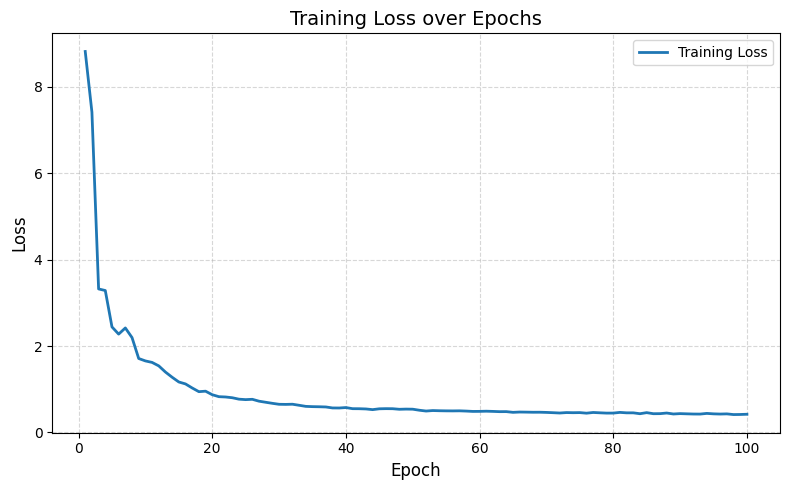

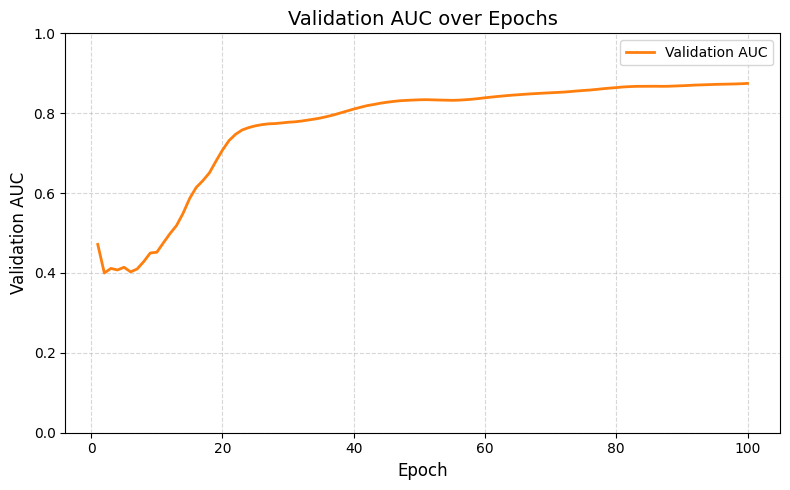


Test AUC: 0.8888 | Test Accuracy: 0.7682 | Test F1: 0.7875 | Test PR AUC: 0.9053
Test Confusion Matrix:
 [[288 137]
 [ 60 365]]


In [103]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model
# Create model
model = GCNLinkPredictor(
    in_channels=128, 
    hidden_channels=64, 
    num_relations=dataset.num_relations,  # From dataset, not train_data
    num_node_types=len(set(dataset.node_types.values()))  # From dataset
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

# Create node type tensor for your data
def create_node_type_tensor(data):
    """Convert node_types dict to tensor with type IDs"""
    unique_types = list(set(data.node_types.values()))
    type_to_id = {node_type: i for i, node_type in enumerate(unique_types)}
    
    node_type_tensor = torch.zeros(data.num_nodes, dtype=torch.long)
    for node_idx, node_type in data.node_types.items():
        node_type_tensor[node_idx] = type_to_id[node_type]
    
    return node_type_tensor

# Add node type tensors to your data
train_data.node_type_tensor = create_node_type_tensor(train_data)
val_data.node_type_tensor = create_node_type_tensor(val_data)
test_data.node_type_tensor = create_node_type_tensor(test_data)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(
        train_data.x.to(device),
        train_data.edge_index.to(device),
        train_data.edge_type.to(device),
        train_data.edge_label_index.to(device),
        train_data.node_type_tensor.to(device)  # Added node types
    )
    loss = loss_fn(out, train_data.edge_label.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(data):
    model.eval()
    logits = model(
        data.x.to(device),
        data.edge_index.to(device),
        data.edge_type.to(device),
        data.edge_label_index.to(device),
        data.node_type_tensor.to(device)  # Added node types
    )
    probs = torch.sigmoid(logits).cpu().numpy()
    labels = data.edge_label.cpu().numpy()
    auc_score = roc_auc_score(labels, probs)
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    precision, recall, _ = precision_recall_curve(labels, probs)
    pr_auc = auc(recall, precision)
    cm = confusion_matrix(labels, preds)
    return auc_score, acc, f1, pr_auc, cm

# Training loop
epochs = 100
train_losses = []
val_aucs = []

for epoch in range(1, epochs+1):
    loss = train()
    train_losses.append(loss)
    val_auc, val_acc, val_f1, val_pr_auc, val_cm = test(val_data)
    val_aucs.append(val_auc)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses, color='tab:blue', label='Training Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss over Epochs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Validation AUC
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), val_aucs, color='tab:orange', label='Validation AUC', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation AUC', fontsize=12)
plt.title('Validation AUC over Epochs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Final evaluation
test_auc, test_acc, test_f1, test_pr_auc, test_cm = test(test_data)
print(f"\nTest AUC: {test_auc:.4f} | Test Accuracy: {test_acc:.4f} | Test F1: {test_f1:.4f} | Test PR AUC: {test_pr_auc:.4f}")
print("Test Confusion Matrix:\n", test_cm)

In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Get prediction probabilities and labels
probs = torch.sigmoid(model(
    test_data.x.to(device),
    test_data.edge_index.to(device),
    test_data.edge_type.to(device),
    test_data.edge_label_index.to(device)
)).cpu().detach().numpy()
labels = test_data.edge_label.cpu().numpy()

# Get edge types for each test link (positives first, then negatives)
num_pos = test_data.test_edge_type.shape[0]
edge_types = test_data.test_edge_type.cpu().numpy()  # shape: [num_pos]
relation_map = getattr(test_data, "relation_map", None)
if relation_map is None:
    relation_map = dataset.relation_map

# Build edge_type array for all test links (positives + negatives)
# For negatives, assign a special type or use the same as positives if you want
all_edge_types = np.concatenate([edge_types, edge_types])  # negatives get same type as positives

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
for rel_type, rel_id in relation_map.items():
    mask = (all_edge_types == rel_id)
    if np.sum(mask) == 0:
        continue
    fpr, tpr, _ = roc_curve(labels[mask], probs[mask])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{rel_type} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve by Edge Type", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

# PR Curve
plt.subplot(1, 2, 2)
for rel_type, rel_id in relation_map.items():
    mask = (all_edge_types == rel_id)
    if np.sum(mask) == 0:
        continue
    precision, recall, _ = precision_recall_curve(labels[mask], probs[mask])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f"{rel_type} (AUC={pr_auc:.2f})")
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve by Edge Type", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

TypeError: GCNLinkPredictor.forward() missing 1 required positional argument: 'node_type'

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Get prediction probabilities and labels
probs = torch.sigmoid(model(
    test_data.x.to(device),
    test_data.edge_index.to(device),
    test_data.edge_type.to(device),
    test_data.edge_label_index.to(device),
    test_data.node_type_tensor.to(device)  # Added node types
)).cpu().detach().numpy()
labels = test_data.edge_label.cpu().numpy()

# Get edge types for each test link (positives first, then negatives)
num_pos = test_data.test_edge_type.shape[0]
edge_types = test_data.test_edge_type.cpu().numpy()  # shape: [num_pos]
relation_map = getattr(test_data, "relation_map", None)
if relation_map is None:
    relation_map = data.relation_map  # Use original data

# Build edge_type array for all test links (positives + negatives)
# For negatives, assign a special type or use the same as positives if you want
all_edge_types = np.concatenate([edge_types, edge_types])  # negatives get same type as positives

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
for rel_type, rel_id in relation_map.items():
    mask = (all_edge_types == rel_id)
    if np.sum(mask) == 0:
        continue
    fpr, tpr, _ = roc_curve(labels[mask], probs[mask])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{rel_type} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve by Edge Type", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

# PR Curve
plt.subplot(1, 2, 2)
for rel_type, rel_id in relation_map.items():
    mask = (all_edge_types == rel_id)
    if np.sum(mask) == 0:
        continue
    precision, recall, _ = precision_recall_curve(labels[mask], probs[mask])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f"{rel_type} (AUC={pr_auc:.2f})")
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve by Edge Type", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

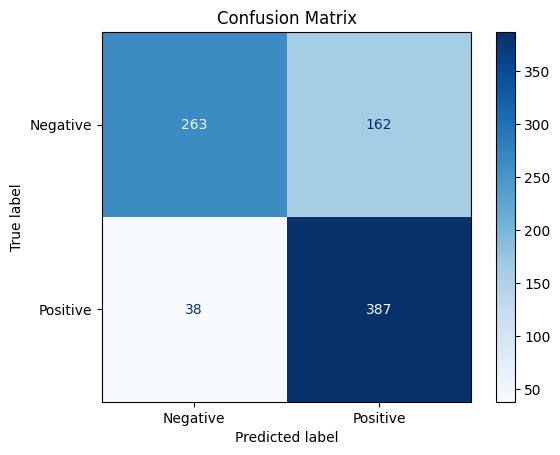

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ...existing code for ROC and PR curves...

# Compute predictions
preds = (probs > 0.5).astype(int)
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

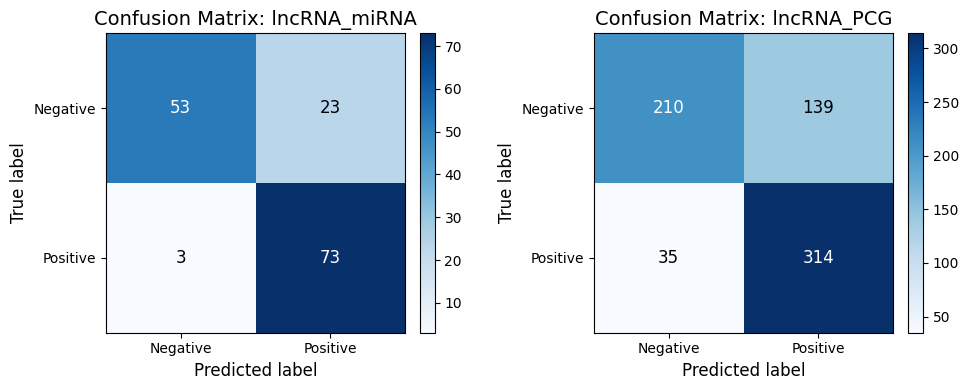

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions and edge types
preds = (probs > 0.5).astype(int)
labels = test_data.edge_label.cpu().numpy()
num_pos = test_data.test_edge_type.shape[0]
edge_types = test_data.test_edge_type.cpu().numpy()
relation_map = getattr(test_data, "relation_map", None)
if relation_map is None:
    relation_map = dataset.relation_map

# Build edge_type array for all test links (positives + negatives)
all_edge_types = np.concatenate([edge_types, edge_types])  # negatives get same type as positives

# Professional confusion matrices for each edge type
fig, axes = plt.subplots(1, len(relation_map), figsize=(5 * len(relation_map), 4))
if len(relation_map) == 1:
    axes = [axes]

for ax, (rel_type, rel_id) in zip(axes, relation_map.items()):
    mask = (all_edge_types == rel_id)
    cm = confusion_matrix(labels[mask], preds[mask])
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f"Confusion Matrix: {rel_type}", fontsize=14)
    ax.set_xlabel("Predicted label", fontsize=12)
    ax.set_ylabel("True label", fontsize=12)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Negative", "Positive"])
    ax.set_yticklabels(["Negative", "Positive"])
    # Annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]}", ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black", fontsize=12)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [77]:
## check out data
import pandas as pd

# Get node features and node names
features = dataset.x.numpy()
node_names = [dataset.idx_to_node[idx] for idx in range(dataset.num_nodes)]

# Create DataFrame
features_df = pd.DataFrame(features, index=node_names)
print(features_df.head(20))

                  0         1         2         3         4         5    \
FZD3         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
STK4         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABI3BP       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
DNAJB9       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
FGF14-AS2    0.051005  0.073432  0.004340  0.069080  0.326841  0.072271   
MDR1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
DUSP6        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
FKBP1A       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
RALY         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
PACERR      -0.093235 -0.016254 -0.010897 -0.175789 -0.036343 -0.149929   
SSTR5        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
RPL34-DT    -0.126355 -0.139995  0.133404 -0.027707 -0.013764  0.206870   
SULT1A1      0.000000  0.

In [4]:

import plotly.graph_objects as go
import plotly.express as px

def visualize_graph_plotly(dataset, width=800, height=600):
    """
    Create an interactive Plotly visualization of the graph
    """
    data = dataset[0]
    
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add nodes with labels
    for idx, node_name in dataset.idx_to_node.items():
        G.add_node(idx, label=node_name)
    
    # Add edges
    edge_index = data.edge_index.numpy()
    edges = [(edge_index[0][i], edge_index[1][i]) for i in range(edge_index.shape[1])]
    G.add_edges_from(edges)
    
    # Generate layout
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Determine node types and colors
    node_types = {}
    for _, row in dataset.net_df.iterrows():
        regulator = row['Regulator']
        target = row['Target']
        reg_type = row['RegulatorType']
        target_type = row['TargetType']
        
        if regulator in dataset.node_to_idx:
            node_types[dataset.node_to_idx[regulator]] = reg_type
        if target in dataset.node_to_idx:
            node_types[dataset.node_to_idx[target]] = target_type
    
    # Prepare edge traces
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#888'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Prepare node traces by type
    color_map = {'lncRNA': '#1f77b4', 'miRNA': '#ff7f0e', 'mRNA': '#2ca02c'}
    node_traces = []
    
    for node_type, color in color_map.items():
        # Filter nodes by type
        node_indices = [idx for idx, ntype in node_types.items() if ntype == node_type]
        
        if node_indices:
            node_x = [pos[idx][0] for idx in node_indices]
            node_y = [pos[idx][1] for idx in node_indices]
            node_labels = [dataset.idx_to_node[idx] for idx in node_indices]
            
            node_trace = go.Scatter(
                x=node_x, y=node_y,
                mode='markers+text',
                text=node_labels,
                textposition="middle center",
                textfont=dict(size=10, color='white'),
                hoverinfo='text',
                hovertext=[f"{label}<br>Type: {node_type}" for label in node_labels],
                marker=dict(
                    size=20,
                    color=color,
                    line=dict(width=2, color='white')
                ),
                name=node_type
            )
            node_traces.append(node_trace)
    
    # Create figure
    fig = go.Figure(data=[edge_trace] + node_traces,
                   layout=go.Layout(
                        title=dict(
                            text='Interactive Regulatory Network Graph',
                            x=0.5,
                            font=dict(size=16)
                        ),
                        showlegend=True,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[ dict(
                            text="Hover over nodes for details. Use mouse to zoom and pan.",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002,
                            xanchor="left", yanchor="bottom",
                            font=dict(color="#888", size=12)
                        )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        width=width,
                        height=height,
                        plot_bgcolor='white'
                        ))
    
    # Show the plot
    fig.show()
    
    # Print statistics
    print(f"Interactive Graph Created!")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.edge_index.size(1)}")
    print(f"Node types: {list(color_map.keys())}")
    print("Features: Zoom, pan, hover for details, toggle node types in legend")

def print_sample_data(dataset):
    """
    Print sample of the original data and processed tensors
    """
    print("Sample Network Data:")
    print(dataset.net_df.head())
    print("\nSample Label Data:")
    print(dataset.label_df.head())
    
    data = dataset[0]
    print(f"\nProcessed PyG Data Object:")
    print(f"Node features shape: {data.x.shape}")
    print(f"Edge index shape: {data.edge_index.shape}")
    print(f"First few edges (source -> target):")
    edge_index = data.edge_index.numpy()
    for i in range(min(5, edge_index.shape[1])):
        source_name = dataset.idx_to_node[edge_index[0][i]]
        target_name = dataset.idx_to_node[edge_index[1][i]]
        print(f"  {source_name} -> {target_name}")

# Example usage (uncomment when you have the CSV files):
dataset = LinkPredictionDataset('data/net.xlsx', 'data/label.xlsx')
print_sample_data(dataset)
visualize_graph_plotly(dataset)  # Interactive Plotly version

Sample Network Data:
   Unnamed: 0  Regulator      Target RegulatorType TargetType  \
0           1      NEAT1  miR-194-5p        lncRNA      miRNA   
1           2  LINC00460     miR-206        lncRNA      miRNA   
2           3     MALAT1     miR-497        lncRNA      miRNA   
3           4       MIAT     miR-29b        lncRNA      miRNA   
4           5      CASC7     miR-30c        lncRNA      miRNA   

  regulatory_Mechanism  
0      ceRNA or sponge  
1      ceRNA or sponge  
2      ceRNA or sponge  
3      ceRNA or sponge  
4      ceRNA or sponge  

Sample Label Data:
   Unnamed: 0      Regulator  cell.proliferation  cell.invasion  \
0           1  1700020I14Rik                   0              0   
1           2            7SK                   1              0   
2           3            91H                   0              1   
3           4        A2M-AS1                   1              1   
4           5          AATBC                   1              0   

   cell.migrati

NameError: name 'nx' is not defined

In [ ]:
# Print a few node names from your graph and from node2vec
print("First 5 graph node names:", [dataset.idx_to_node[idx] for idx in range(5)])
node2vec_df = pd.read_csv("/Users/marinamomina/Desktop/studium/master/1_Sem/ML4RG/LincGNN/NodePre/lncRNA_emb_features.csv", index_col=0)
print("First 5 node2vec index names:", list(node2vec_df.index[:5]))

First 5 graph node names: ['RP11-543N12.1', 'RP11-789C1.1', 'ATM', 'RAB10', 'SLCO4A1']
First 5 node2vec index names: ['NEAT1', 'LINC00460', 'MALAT1', 'MIAT', 'CDKN2B-AS1']
